# Library

In [1204]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json


torch.manual_seed(0)


# Data Exploration

In [1205]:
df_train = pd.read_csv("data/review.csv")
df_val = pd.read_csv("data/validation.csv")

In [1206]:
df_train

,ReviewerID,ProductID,Text,Summary,Star
0,A1XJXYKOWCH9XT,B000FBFMHU,Liked the movie. Loved the book. It really giv...,Liked the movie. Loved the book!,5.0
1,A1K4S4MWXI9E9M,B000FC27TA,Purchased more out of curiosity than any real ...,"Not my favorite, but...",3.0
2,A3LF914GG87TWP,B000FC27TA,"I actually received this text as an ebook, sin...",An interesting read,4.0
3,A1CNQTCRQ35IMM,B000FCKPG2,REVIEWER'S OPINION:\nThis was labeled as roman...,This was labeled romance but there was less ro...,2.0
4,AU510CVD9XDG,B000GCFWXW,I have been saving the Argeneau novels for awh...,Science Fiction not Paranormal Romance,2.0
...,...,...,...,...,...
52507,A3JVZY05VLMYEM,B01FLJUZ0E,She can't do anything right according to her f...,What Can She Do,5.0
52508,A2U06P692IZOSF,B01FLJUZ0E,Better late than never!!\nKitty Konstantine ha...,BART & KITTY CAT MAKE SPARKS FLY!!,5.0
52509,A3RPL8JIS2XMJ3,B01FLJUZ0E,This book was great. Bartholomew finally gets ...,LOVE THE SAINTS,5.0
52510,A1XMFCMIANCQRW,B01FPYJS1M,I read for a honest review for the author.\nTh...,"Loved Lee and Raina together, Ricky is evil an...",4.0


In [1207]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52512 entries, 0 to 52511
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ReviewerID  52512 non-null  object 
 1   ProductID   52512 non-null  object 
 2   Text        52512 non-null  object 
 3   Summary     52507 non-null  object 
 4   Star        52512 non-null  float64
dtypes: float64(1), object(4)
memory usage: 2.0+ MB


In [1208]:
print("The number of reviewers: ", len(df_train['ReviewerID'].unique()))
print("The number of products: ", len(df_train['ProductID'].unique()))


The number of reviewers:  2752
The number of products:  6336


In [1209]:
# with open("data/product.json","r") as f:
#     product = json.load(f)
    
# product

In [1210]:
# print("The number of product: ",len(product))

# Data Preprocessing

In [1211]:
def create_mapping(df:pd.DataFrame):
    reviewerID = df['ReviewerID'].unique()
    productID = df['ProductID'].unique()

    reviewerID_map = {reviewerID: i+1 for i, reviewerID in enumerate(reviewerID)}
    productID_map = {productID: i+1 for i, productID in enumerate(productID)}
    return reviewerID_map, productID_map


In [1212]:
reviewer_map, product_map = create_mapping(df_train)


# Data Loader

In [1213]:
class RatingDataset(Dataset):
    def __init__(self, df:pd.DataFrame, reviewer_map, product_map):
        reviewerID = df['ReviewerID'].map(reviewer_map).fillna(0).astype(int)
        productID = df['ProductID'].map(product_map).fillna(0).astype(int)
        self.reviwers = torch.tensor(reviewerID.values,dtype=torch.long)
        self.products = torch.tensor(productID.values, dtype=torch.long)
        self.stars = torch.tensor(df['Star'].values, dtype=torch.float)
    
    def __len__(self):
        return len(self.stars)
    
    def __getitem__(self, index):
        return self.reviwers[index], self.products[index], self.stars[index] 

# Model

In [1214]:
class NeuralCF(nn.Module):
    def __init__(self,num_reviewers, num_products, embedding_dim=50, hidden_dim=64):
        super().__init__()
        self.reviewer_embedding = nn.Embedding(num_reviewers+1, embedding_dim,padding_idx=0)
        self.product_embedding = nn.Embedding(num_products+1, embedding_dim,padding_idx=0)
        self.fc_layers = nn.Sequential(
            nn.Linear(2*embedding_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.BatchNorm1d(hidden_dim//2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim//2, hidden_dim//4),
            nn.BatchNorm1d(hidden_dim//4),
            nn.Linear(hidden_dim//4, 1)
        )
    def forward(self, reviewer, product):
        reviewer_vec = self.reviewer_embedding(reviewer)
        product_vec = self.product_embedding(product)
        concat = torch.cat([reviewer_vec,product_vec], dim=1)
        return self.fc_layers(concat).squeeze()


# Training

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using {}".format(device))

model = NeuralCF(len(reviewer_map), len(product_map))
model.to(device)

lossFn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)

train_dataset = RatingDataset(df_train,reviewer_map,product_map)
train_loader = DataLoader(train_dataset,batch_size=32, shuffle=True)
val_dataset = RatingDataset(df_val,reviewer_map,product_map)
val_loader = DataLoader(val_dataset,batch_size=32, shuffle=True)


losses_train = []
losses_val = []

epoch = 15
for e in range(epoch):
    model.train()
    train_loss = 0
    for reviewer, product, star in train_loader:
        reviewer,product,star = reviewer.to(device), product.to(device), star.to(device)
        optimizer.zero_grad()
        pred = model(reviewer,product)
        loss = lossFn(pred, star)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    losses_train.append(avg_train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for reviewer, product, star in val_loader:
            reviewer,product,star = reviewer.to(device), product.to(device), star.to(device)
            pred = model(reviewer,product)
            loss = lossFn(pred,star)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    losses_val.append(avg_val_loss)



    print(f"Epoch {e+1}, Train loss: {avg_train_loss:.4f}, Validation loss: {avg_val_loss:.4f}")

Using cpu
Epoch 1, Train loss: 7.1303, Validation loss: 7.0749
Epoch 2, Train loss: 0.9609, Validation loss: 7.0304
Epoch 3, Train loss: 0.9428, Validation loss: 6.9750
Epoch 4, Train loss: 0.9276, Validation loss: 6.8302
Epoch 5, Train loss: 0.9065, Validation loss: 6.6072
Epoch 6, Train loss: 0.8720, Validation loss: 6.2118
Epoch 7, Train loss: 0.8284, Validation loss: 5.9149
Epoch 8, Train loss: 0.7888, Validation loss: 5.4084
Epoch 9, Train loss: 0.7441, Validation loss: 5.1203
Epoch 10, Train loss: 0.6942, Validation loss: 4.6667
Epoch 11, Train loss: 0.6473, Validation loss: 4.3912
Epoch 12, Train loss: 0.6063, Validation loss: 4.1324
Epoch 13, Train loss: 0.5739, Validation loss: 3.7322
Epoch 14, Train loss: 0.5466, Validation loss: 3.5509
Epoch 15, Train loss: 0.5268, Validation loss: 3.4006


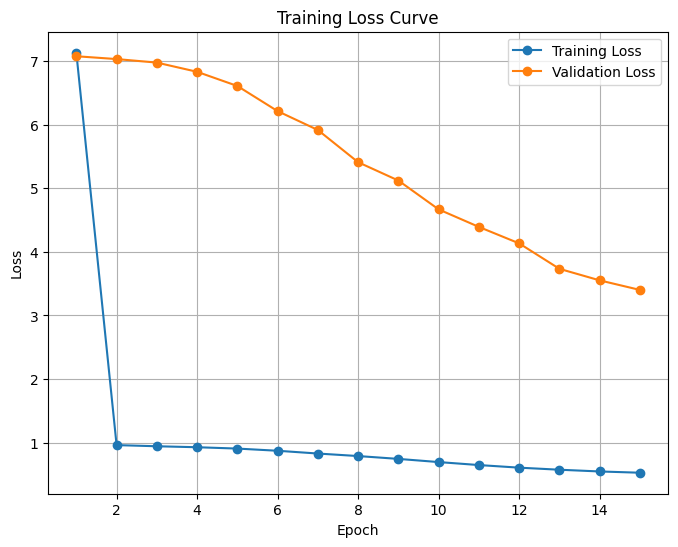

In [1216]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(losses_train) + 1), losses_train, marker='o', label="Training Loss")
plt.plot(range(1, len(losses_val) + 1), losses_val, marker='o', label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

In [1217]:
def compute_rmse(model, loader):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for user, item, rating in loader:
            user, item, rating = user.to(device), item.to(device), rating.to(device)
            pred = model(user, item)
            total_loss += nn.MSELoss(reduction='sum')(pred, rating).item()
    mse = total_loss / len(loader.dataset)
    return torch.sqrt(torch.tensor(mse)).item()

train_rmse = compute_rmse(model, train_loader)
val_rmse = compute_rmse(model, val_loader)

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")

Train RMSE: 0.6549
Validation RMSE: 0.8546


# Predict the Testing Dataset

In [1218]:
df_test = pd.read_csv("data/validation.csv")
df_test

,ReviewerID,ProductID,Star
0,A25X28UZCW2J6G,B00K9V6B94,4.0
1,A1FUH1O6FCTUYG,B00GZANS6M,5.0
2,AAUVEEG5YLZAX,B01864DDVO,5.0
3,A3VQLGTYTL5196,B001BXNQ2O,5.0
4,A10JAUCIGVRW9F,B0116MZUS2,5.0
...,...,...,...
6591,A3TC60MGLW1I76,B00EHSUFD8,4.0
6592,AGE0YGLF7L2ZL,B014LQ18CW,4.0
6593,AT2ZB20OCU7X2,B00ZRDPPU0,4.0
6594,A1ACUN6A2LYVMW,B01EKIELGG,1.0


In [1219]:
test_dataset = RatingDataset(df_test,reviewer_map,product_map)
test_dataloader = DataLoader(test_dataset,batch_size=1,shuffle=False)

star = []

model.eval()
with torch.no_grad():
    for reviewer, product, _ in test_dataloader:
            reviewer,product = reviewer.to(device), product.to(device)
            predict = model(reviewer,product)
            star.append(predict.item())

df_test['Star'] = star

        

In [1220]:
df_test

,ReviewerID,ProductID,Star
0,A25X28UZCW2J6G,B00K9V6B94,3.895925
1,A1FUH1O6FCTUYG,B00GZANS6M,4.424045
2,AAUVEEG5YLZAX,B01864DDVO,4.052550
3,A3VQLGTYTL5196,B001BXNQ2O,4.644440
4,A10JAUCIGVRW9F,B0116MZUS2,4.769746
...,...,...,...
6591,A3TC60MGLW1I76,B00EHSUFD8,3.202310
6592,AGE0YGLF7L2ZL,B014LQ18CW,4.287699
6593,AT2ZB20OCU7X2,B00ZRDPPU0,4.751717
6594,A1ACUN6A2LYVMW,B01EKIELGG,3.761259


In [1221]:
df_test.to_csv('validation_prediction.csv',index=False)

In [1222]:
from evaluate import rmse

val_df = pd.read_csv("data/validation.csv")

pred_df = pd.read_csv("validation_prediction.csv")

df = pd.merge(
    val_df,
    pred_df,
    how="left",
    left_on=["ReviewerID", "ProductID"],
    right_on=["ReviewerID", "ProductID"],
)
print(df.shape)
df.fillna(0, inplace=True)
df.head()

print("VALIDATION RMSE: ", rmse(df["Star_y"].values, df["Star_x"].values))

(6596, 4)
VALIDATION RMSE:  0.8545701644087859


In [1223]:
df

,ReviewerID,ProductID,Star_x,Star_y
0,A25X28UZCW2J6G,B00K9V6B94,4.0,3.895925
1,A1FUH1O6FCTUYG,B00GZANS6M,5.0,4.424045
2,AAUVEEG5YLZAX,B01864DDVO,5.0,4.052550
3,A3VQLGTYTL5196,B001BXNQ2O,5.0,4.644440
4,A10JAUCIGVRW9F,B0116MZUS2,5.0,4.769746
...,...,...,...,...
6591,A3TC60MGLW1I76,B00EHSUFD8,4.0,3.202310
6592,AGE0YGLF7L2ZL,B014LQ18CW,4.0,4.287699
6593,AT2ZB20OCU7X2,B00ZRDPPU0,4.0,4.751717
6594,A1ACUN6A2LYVMW,B01EKIELGG,1.0,3.761259
